### Initialization cells

In [1]:
import os, sys
# my functions
home = os.path.expanduser('~')
sys.path.append("{}/2019SumProj/code/conformer-ml/Python/tests".format(home))
from conformer_generator import * # have to make sure this is in PATH
from utility_functions import * # have to make sure this is in PATH
# from deepchem.utils import conformers # don't import this if using conformer_generator.py

import copy
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from deepchem.feat import atomic_coordinates
from rdkit import Chem, RDConfig, rdBase
from rdkit import rdBase
from rdkit.Chem import AllChem, TorsionFingerprints, rdMolDescriptors
# for visualizing molecules
from rdkit.Chem import Draw,PyMol,rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Cluster import Butina
# IPythonConsole.ipython_useSVG = True

print("Modules and packages loaded.")
print("RDKit version: {}".format(rdBase.rdkitVersion))
# print("DeepChem version: {}".format(deepchem.__version__))
print("Current directory is {}".format(os.getcwd()))

ModuleNotFoundError: No module named 'conformer_generator'

In [4]:
## input directories and files & ConformerGenerator
nb_dir = "{}/2019SumProj/conf_gen/notebooks".format(home)

# Confab
confab_dir = "{}/2019SumProj/conf_gen/confab_template".format(home)
confab_molname = "lignin_model_compound_1a"
confab_wd = confab_dir + "/{}/".format(confab_molname)
print("Confab files in ", confab_wd)

# MD
md_molname = "lignin_guaiacyl"
tlength = "1microsec" 
md_dir = "{}/2019SumProj/conf_gen/md_template".format(home)
md_wd = md_dir + "/{}/{}/".format(md_molname, tlength)
print("MD files in ", md_wd)

# IQMol user data paths
iqmol_molname = "lignin"
users_dir = "{}/users_iqmol/".format(home)
input_dir = home + '/inputs_iqmol/'
iqmol_wd = users_dir + "lignin1a_results/"
print("IQMol user files in ", iqmol_wd)

num_files = 25000
rmsd_threshold = 0.0
tfd_threshold = 0.0
ff_type = "mmff"
# instantiating confgen Class
confgen = ConformerGeneratorCustom(max_conformers=num_files,
                                   rmsd_threshold=rmsd_threshold,
                                   tfd_threshold=tfd_threshold,
                                   force_field=ff_type,
                                   pool_multiplier=1)


Confab files in  /Users/exequielpunzalan/2019SumProj/conf_gen/confab_template/lignin_model_compound_1a/
MD files in  /Users/exequielpunzalan/2019SumProj/conf_gen/md_template/lignin_guaiacyl/1microsec/
IQMol user files in  /Users/exequielpunzalan/users_iqmol/lignin1a_results/


In [202]:
## for 5000 LECs for now
## loading pickle files & rmsd/tfd arrays
## 1.5A rmsd, 0.002 tfd (0.02tfd for MD because no 0.002)
## 5000 LEC ncutoff then rcutoff for MD & Confab

confab_rcutoff = 1.5
confab_tcutoff = 0.002
iqmol_rcutoff = 0
iqmol_tcutoff = 0
md_rcutoff = 1.5
md_tcutoff = 0.02

# Confab
with open(confab_wd + "pruned_mols/pruned_mol_1.5rmsd.pkl", 'rb') as pickle_file:
    confab_mol_rmsd = pickle.load(pickle_file)
confab_rmsd = np.load(confab_wd + "pruned_mols/5000Lecs_1.5rmsd.npy")
with open(confab_wd + "pruned_mols/pruned_mol_0.002tfd.pkl", 'rb') as pickle_file:
    confab_mol_tfd = pickle.load(pickle_file)
confab_tfd = np.load(confab_wd + "pruned_mols/5000Lecs_0.002tfd.npy")

# IQMol no cutoffs
# with open(iqmol_wd + "pruned_mols/pruned_mol_0.5rmsd.pkl", 'rb') as pickle_file:
#     iqmol_mol_rmsd = pickle.load(pickle_file)
# iqmol_rmsd = np.load(iqmol_wd + "pruned_mols/0.5rmsd.npy")
# with open(iqmol_wd + "pruned_mols/pruned_mol_0.05tfd.pkl", 'rb') as pickle_file:
#     iqmol_mol_tfd = pickle.load(pickle_file)
# iqmol_tfd = np.load(iqmol_wd + "pruned_mols/0.05tfd.npy")
with open(iqmol_wd + "pruned_mols/pruned_mol_0rmsd_sortedEnergies.pkl", 'rb') as pickle_file:
    iqmol_mol_rmsd = pickle.load(pickle_file)
iqmol_rmsd = np.load(iqmol_wd + "pruned_mols/0icrmsd.npy")
with open(iqmol_wd + "pruned_mols/pruned_mol_0tfd_sortedEnergies.pkl", 'rb') as pickle_file:
    iqmol_mol_tfd = pickle.load(pickle_file)
iqmol_tfd = np.load(iqmol_wd + "pruned_mols/0ictfd.npy")

# MD
# 5000ncutoff is 5000 LECs pruned
# 5000frames if first 5000 frames pruned
# with open(md_wd + "pruned_mols/5000ncutoff_pruned_mol_1.5rmsd.pkl", 'rb') as pickle_file:
#     md_mol_rmsd = pickle.load(pickle_file)
# md_rmsd = np.load(md_wd + "pruned_mols/5000ncutoff_1.5rmsd.npy")
# with open(md_wd + "pruned_mols/5000ncutoff_pruned_mol_0.02tfd.pkl", 'rb') as pickle_file:
#     md_mol_tfd = pickle.load(pickle_file)
# md_tfd = np.load(md_wd + "pruned_mols/5000ncutoff_0.02tfd.npy")

md_rmsd = np.load(md_wd + "pruned_mols/0icrmsd.npy")
md_tfd = np.load(md_wd + "pruned_mols/0ictfd.npy")

print("Molecules loaded.")

confab_nconfs_rmsd = confab_mol_rmsd.GetNumConformers()
confab_nconfs_tfd = confab_mol_tfd.GetNumConformers()
md_nconfs_rmsd = md_mol_rmsd.GetNumConformers()
md_nconfs_tfd = md_mol_tfd.GetNumConformers()
iqmol_nconfs_rmsd = iqmol_mol_rmsd.GetNumConformers()
iqmol_nconfs_tfd = iqmol_mol_tfd.GetNumConformers()
print("Confab: {} conformers with {} rmsd pruning, {} with {} tfd".format(confab_nconfs_rmsd, confab_rcutoff, confab_nconfs_tfd, confab_tcutoff))
# print("MD: {} confs with {} rmsd, {} confs with {} tfd".format(md_nconfs_rmsd, md_rcutoff, md_nconfs_tfd, md_tcutoff))
print("IQMol users: {} confs with {} rmsd, {} confs with {} tfd".format(iqmol_nconfs_rmsd, iqmol_rcutoff, iqmol_nconfs_tfd, iqmol_tcutoff))



Molecules loaded.
Confab: 24 conformers with 1.5 rmsd pruning, 1893 with 0.002 tfd
IQMol users: 83 confs with 0 rmsd, 83 confs with 0 tfd


In [203]:
print(md_rmsd.shape)
print(md_tfd.shape)

(5000, 5000)
(5000, 5000)


In [52]:
# pruning
with open(iqmol_wd + "mol_mmff_minimized.pkl", 'rb') as pickle_file:
    mol = pickle.load(pickle_file)
mol_with_LEC = mol
ncutoff = 1000
rmsd_thresholds = [0.50]
tfd_thresholds = [0.05]

for i in range(len(rmsd_thresholds)):
    confgen = ConformerGeneratorCustom(max_conformers=ncutoff,
                                       rmsd_threshold=rmsd_thresholds[i],
                                       tfd_threshold=tfd_thresholds[i],
                                       force_field="mmff",
                                       pool_multiplier=1)
    print("rmsd {}/tfd {} pruning".format(rmsd_thresholds[i], tfd_thresholds[i]))
    rmsd = ConformerGeneratorCustom.get_conformer_rmsd_fast(mol_with_LEC)
    pruned_mol_rmsd, pruned_rmsd = confgen.prune_conformers(mol_with_LEC, rmsd, measure="rmsd")
    print("RMSD nconfs: {}".format(pruned_mol_rmsd.GetNumConformers()))
    tfd = ConformerGeneratorCustom.get_tfd_matrix(mol_with_LEC)
    pruned_mol_tfd, pruned_tfd = confgen.prune_conformers(mol_with_LEC, tfd, measure="tfd")
    print("TFD nconfs: {}".format(pruned_mol_tfd.GetNumConformers()))
    
    # saving pruned molecules
    mols_save_dir = users_dir + "lignin1a_results/pruned_mols/"
    with open(mols_save_dir + "pruned_mol_{}rmsd.pkl".format(confgen.rmsd_threshold), 'wb') as pickle_file:
        pickle.dump(pruned_mol_rmsd, pickle_file)
    with open(mols_save_dir + "pruned_mol_{}tfd.pkl".format(confgen.tfd_threshold), 'wb') as pickle_file:
        pickle.dump(pruned_mol_tfd, pickle_file)
    np.save(mols_save_dir + "pruned_mol_{}rmsd.npy".format(confgen.rmsd_threshold), pruned_rmsd)
    np.save(mols_save_dir + "pruned_mol_{}tfd.npy".format(confgen.tfd_threshold), pruned_tfd)

rmsd 0.5/tfd 0.05 pruning
RMSD nconfs: 57
TFD nconfs: 37


In [11]:
print(confab_mol_rmsd.GetNumAtoms())
print(confab_mol_tfd.GetNumAtoms())
print(md_mol_rmsd.GetNumAtoms())
print(md_mol_tfd.GetNumAtoms())
print(iqmol_mol_rmsd.GetNumAtoms())
print(iqmol_mol_tfd.GetNumAtoms())

46
46
46
46
46
46


### Distance Maps

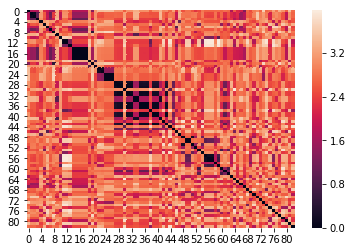

In [147]:
# https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
ax = sns.heatmap(iqmol_rmsd)
plt.show()

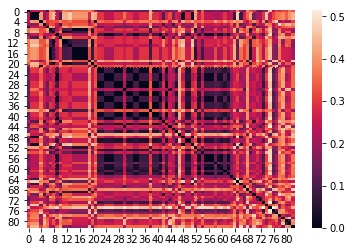

In [146]:
ax = sns.heatmap(iqmol_tfd)
plt.show()

In [28]:
# # lower triangle of symmetric matrix
# mask = np.zeros_like(iqmol_rmsd)
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#     ax = sns.heatmap(iqmol_rmsd, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
#     plt.show()

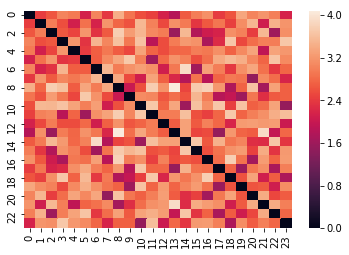

In [19]:
ax = sns.heatmap(confab_rmsd)
plt.show()

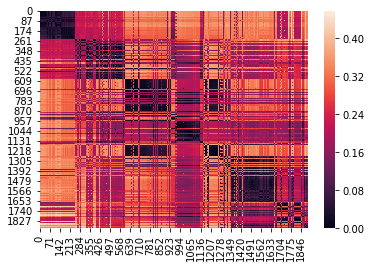

In [145]:
ax = sns.heatmap(confab_tfd)
plt.show()

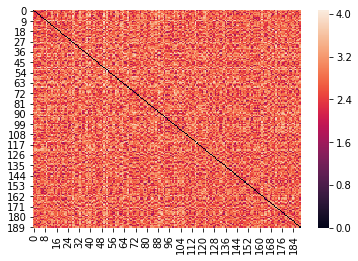

In [22]:
ax = sns.heatmap(md_rmsd)
plt.show()

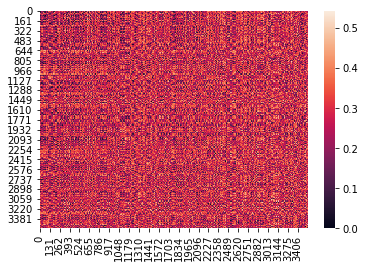

In [144]:
ax = sns.heatmap(md_tfd)
plt.show()

### Butina clustering

In [29]:
# symmetric rmsd/tfd matrices into lower triangle 1d arrays
confab_rmsd_lt = symmetric_to_array(confab_rmsd)
confab_tfd_lt = symmetric_to_array(confab_tfd)
md_rmsd_lt = symmetric_to_array(md_rmsd)
md_tfd_lt = symmetric_to_array(md_tfd)
iqmol_rmsd_lt = symmetric_to_array(iqmol_rmsd)
iqmol_tfd_lt = symmetric_to_array(iqmol_tfd)

In [35]:
# Butina clustering
confab_rmsd_clusters = Butina.ClusterData(confab_rmsd_lt, confab_nconfs_rmsd, 0.5, isDistData=True, reordering=True)
confab_tfd_clusters = Butina.ClusterData(confab_tfd_lt, confab_nconfs_tfd, 0.001, isDistData=True, reordering=True)

In [36]:
print(len(confab_rmsd_clusters))
print(len(confab_tfd_clusters))

24
1893


### Dendrograms

In [37]:
## clustering on IQMol data
# http://mdtraj.org/latest/examples/clustering.html
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

In [116]:
# Clustering only accepts reduced form. Squareform's checks are too stringent
assert np.all(iqmol_rmsd - iqmol_rmsd.T < 1e-6)
reduced_iqmol_rmsd = squareform(iqmol_rmsd, checks=False)

In [127]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# i.e. elements in the upper triangular part of the square distance matrix, strung together into a 1D array
rmsd_Z = scipy.cluster.hierarchy.linkage(reduced_iqmol_rmsd, method='single')

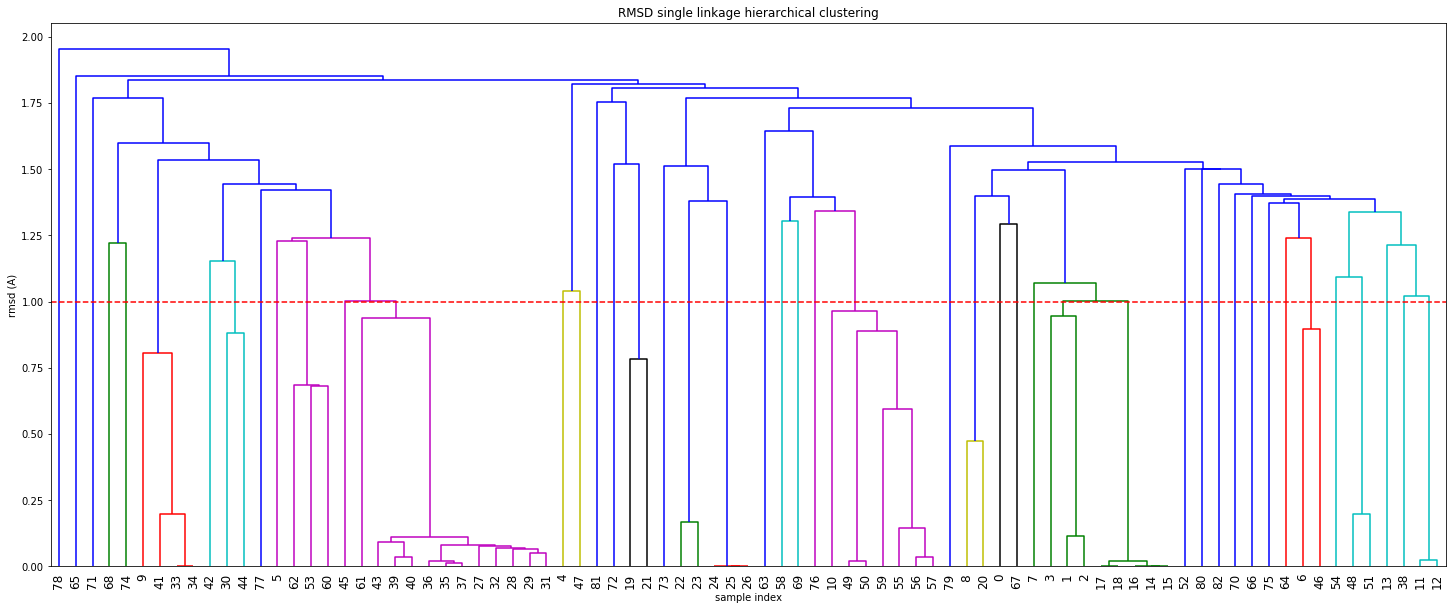

In [193]:
plt.figure(figsize=(25, 10))
plt.title('RMSD single linkage hierarchical clustering')
plt.xlabel('sample index')
plt.ylabel('rmsd (A)')
plt.axhline(y=1.0, color='r', linestyle='--')
_ = scipy.cluster.hierarchy.dendrogram(rmsd_Z, no_labels=False, count_sort='descendent', leaf_rotation=90., leaf_font_size=12.,)

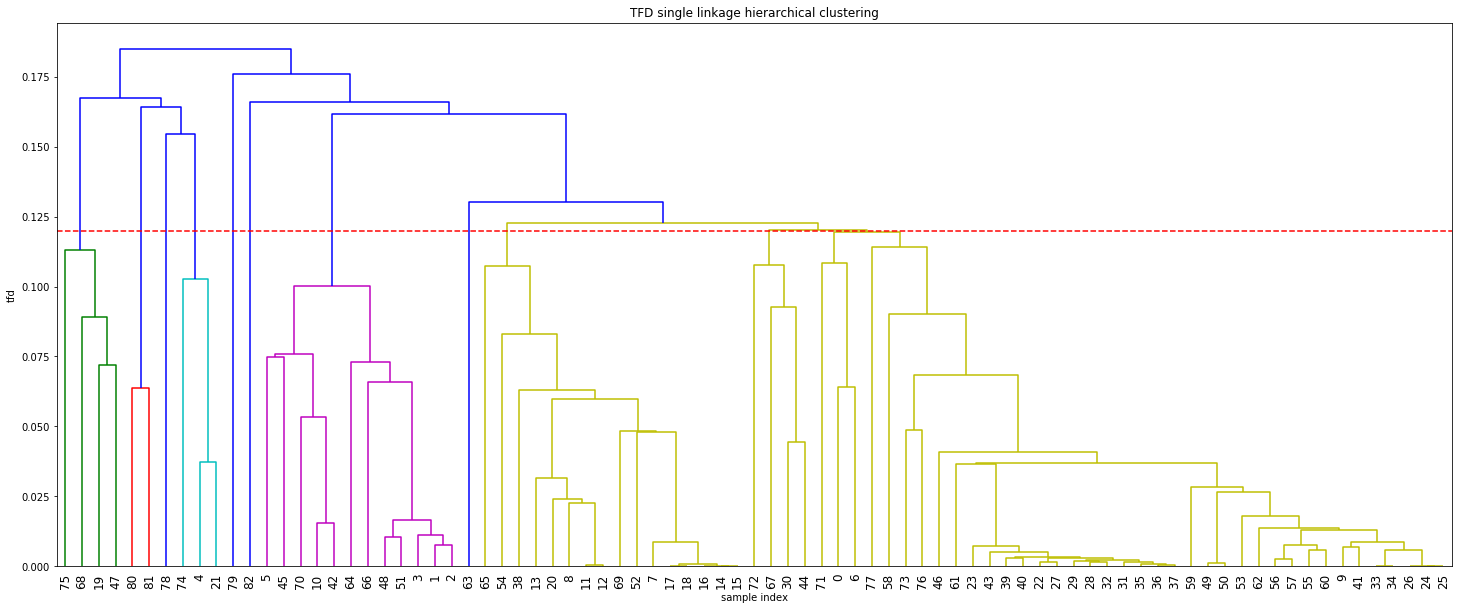

In [192]:
# TFD
assert np.all(iqmol_tfd - iqmol_tfd.T < 1e-6)
reduced_iqmol_tfd = squareform(iqmol_tfd, checks=False)

tfd_Z = scipy.cluster.hierarchy.linkage(reduced_iqmol_tfd, method='single')

plt.figure(figsize=(25, 10))
plt.title('TFD single linkage hierarchical clustering')
plt.xlabel('sample index')
plt.ylabel('tfd')
plt.axhline(y=0.120, color='r', linestyle='--')
_ = scipy.cluster.hierarchy.dendrogram(tfd_Z, no_labels=False, count_sort='descendent', leaf_rotation=90., leaf_font_size=12.,)

In [71]:
# # sklearn
# from sklearn.cluster import AgglomerativeClustering 
# import scipy.cluster.hierarchy as shc 

# plt.figure(figsize =(25, 10)) 
# plt.title('Visualising the data') 
# Dendrogram = shc.dendrogram((shc.linkage(reduced_iqmol_rmsd, method ='single'))) 

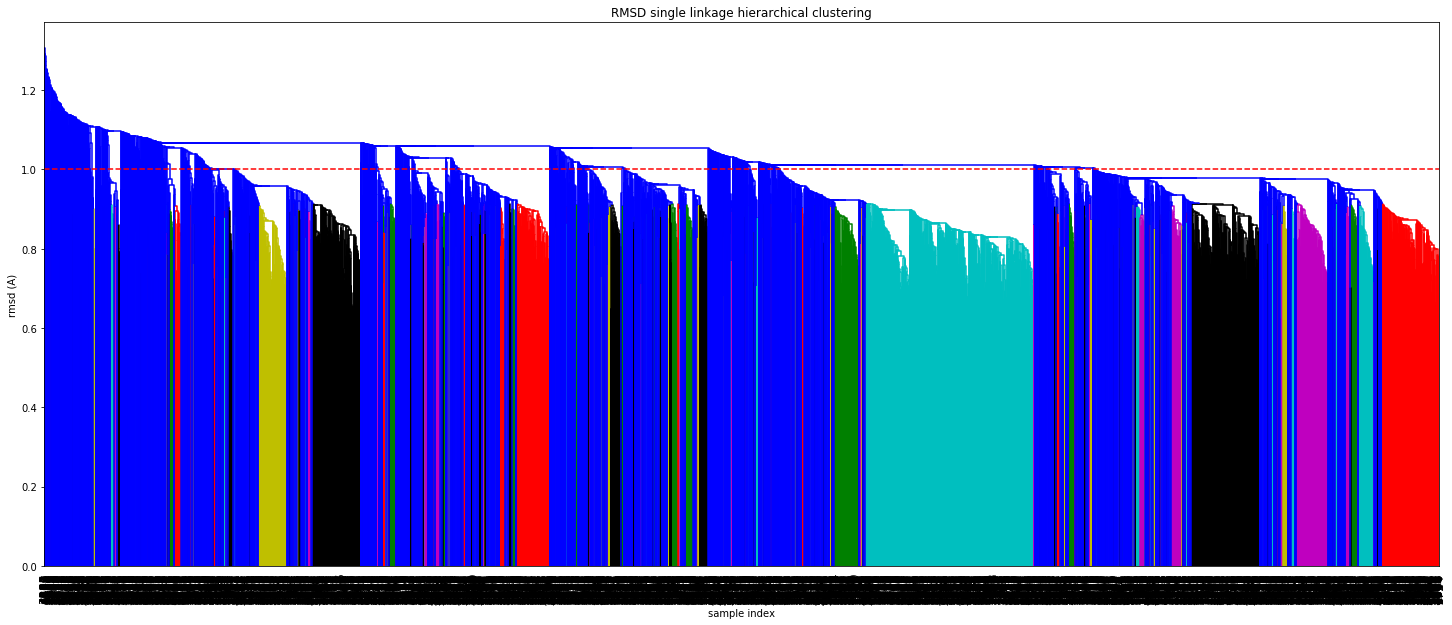

In [204]:
reduced_md_rmsd = squareform(md_rmsd, checks=False)
md_rmsd_Z = scipy.cluster.hierarchy.linkage(reduced_md_rmsd, method='single')

plt.figure(figsize=(25, 10))
plt.title('RMSD single linkage hierarchical clustering')
plt.xlabel('sample index')
plt.ylabel('rmsd (A)')
plt.axhline(y=1.0, color='r', linestyle='--')
_ = scipy.cluster.hierarchy.dendrogram(md_rmsd_Z, no_labels=False, count_sort='descendent', leaf_rotation=90., leaf_font_size=12.,)

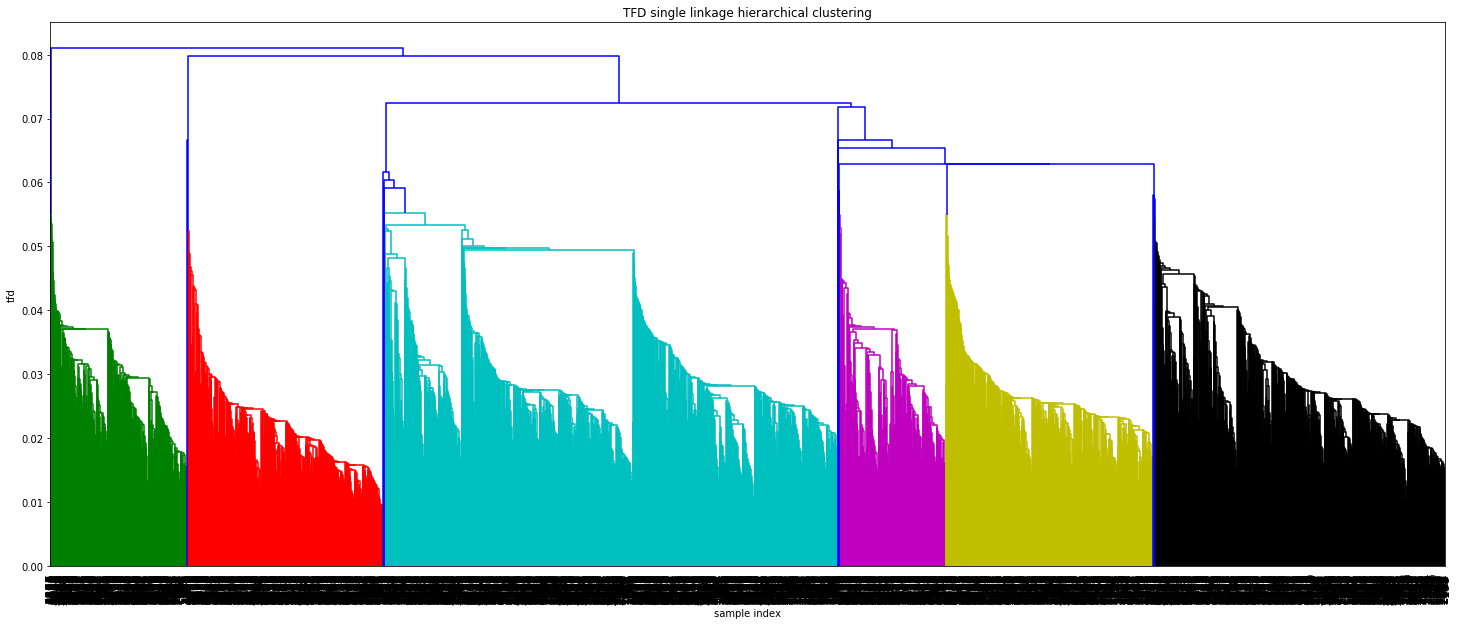

In [208]:
reduced_md_tfd = squareform(md_tfd, checks=False)
md_tfd_Z = scipy.cluster.hierarchy.linkage(reduced_md_tfd, method='single')

plt.figure(figsize=(25, 10))
plt.title('TFD single linkage hierarchical clustering')
plt.xlabel('sample index')
plt.ylabel('tfd')
plt.axhline(y=1.0, color='r', linestyle='--')
_ = scipy.cluster.hierarchy.dendrogram(md_tfd_Z, no_labels=False, count_sort='descendent', leaf_rotation=90., leaf_font_size=12.,)

### Dendrogram functions and truncated dendrograms

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [137]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib
# https://python-graph-gallery.com/401-customised-dendrogram/
def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata

print("Dendogram functions here.")

Dendogram functions here.


In [129]:
# condensed matrix
assert np.all(iqmol_rmsd - iqmol_rmsd.T < 1e-6)
reduced_iqmol_rmsd = squareform(iqmol_rmsd, checks=False)
rmsd_Z = scipy.cluster.hierarchy.linkage(reduced_iqmol_rmsd, method='single')

assert np.all(iqmol_tfd - iqmol_tfd.T < 1e-6)
reduced_iqmol_tfd = squareform(iqmol_tfd, checks=False)
tfd_Z = scipy.cluster.hierarchy.linkage(reduced_iqmol_tfd, method='single')

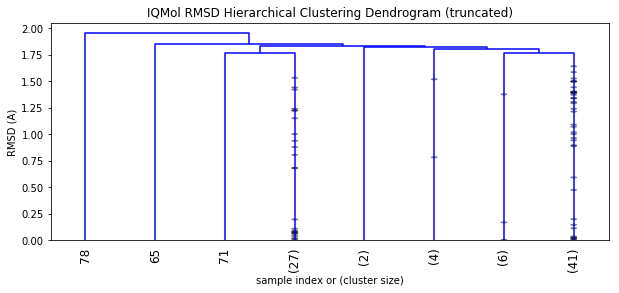

In [199]:
plt.figure(figsize=(10, 4))
plt.title('IQMol RMSD Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('RMSD (A)')
dendrogram(
    rmsd_Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

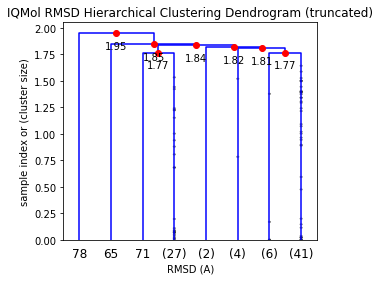

In [197]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('IQMol RMSD Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel("RMSD (A)")
plt.ylabel("sample index or (cluster size)")

show_leaf_counts = True
ddata = augmented_dendrogram(rmsd_Z,
               color_threshold=1,
               p=8,
               truncate_mode='lastp',
               show_leaf_counts=show_leaf_counts,
               show_contracted=True
               )
# plt.title("show_leaf_counts = %s" % show_leaf_counts)


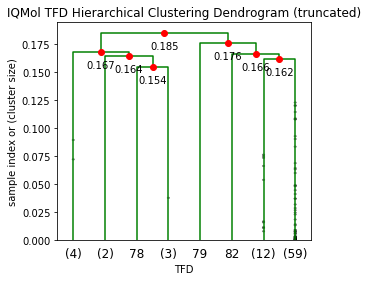

In [198]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('IQMol TFD Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel("TFD")
plt.ylabel("sample index or (cluster size)")

show_leaf_counts = True
ddata = augmented_dendrogram(tfd_Z,
               color_threshold=1,
               p=8,
               truncate_mode='lastp',
               show_leaf_counts=show_leaf_counts,
               show_contracted=True
               )
# plt.title("show_leaf_counts = %s" % show_leaf_counts)


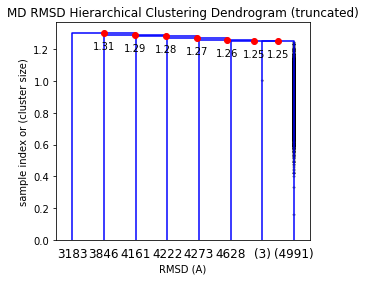

In [205]:
## MD

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('MD RMSD Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel("RMSD (A)")
plt.ylabel("sample index or (cluster size)")

show_leaf_counts = True
ddata = augmented_dendrogram(md_rmsd_Z,
               color_threshold=1,
               p=8,
               truncate_mode='lastp',
               show_leaf_counts=show_leaf_counts,
               show_contracted=True
               )
# plt.title("show_leaf_counts = %s" % show_leaf_counts)


In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('MD TFD Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel("TFD")
plt.ylabel("sample index or (cluster size)")

show_leaf_counts = True
ddata = augmented_dendrogram(md_tfd_Z,
               color_threshold=1,
               p=8,
               truncate_mode='lastp',
               show_leaf_counts=show_leaf_counts,
               show_contracted=True
               )
# plt.title("show_leaf_counts = %s" % show_leaf_counts)


### Clustering with scipy

In [157]:
# https://stackoverflow.com/questions/55950591/single-linkage-clustering-of-edit-distance-matrix-with-distance-threshold-stoppi/55957258#55957258
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import metrics

def cluster_mat(mat, method='single', threshold=100):
    '''
    Accepts a square distance matrix
    Performs single linkage clustering by default, see scipy.cluster.hierarchy.linkage docs for others
    '''
    reduced_mat = squareform(mat, checks=False)
    clusters = fcluster(linkage(reduced_mat,
                                method=method,
                                metric='precomputed'),
                        criterion='distance',
                        t=threshold) # depends on which criterion is used
    return clusters

In [219]:
# IQMol different rmsd cutoffs
rmsd_thresholds = [0.20, 0.40, 0.60, 1.00, 1.20, 1.40, 1.60, 1.80]
clusters_rmsd = []
silhouette_scores = []
for t in rmsd_thresholds:
    clusters = cluster_mat(iqmol_rmsd, method='single', threshold=t) # cluster indices for each of the inp observations
    clusters_rmsd.append(clusters)
#     Results of fcluster can directly be fed into silhouette_score.
#     https://stackoverflow.com/questions/27875056/how-to-calculate-silhouette-score-of-the-scipys-fcluster-using-scikit-learn-sil
    score = metrics.silhouette_score(iqmol_rmsd, labels=clusters, metric='precomputed')
    silhouette_scores.append(score)

Text(0.5,0,'RMSD threshold (A)')

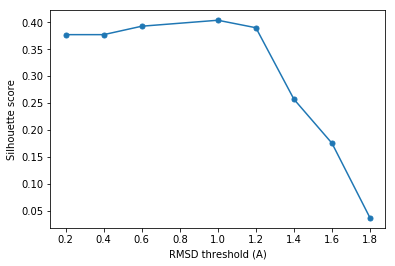

In [183]:
plt.plot(rmsd_thresholds, silhouette_scores, marker='.', markersize=10)
plt.ylabel("Silhouette score")
plt.xlabel("RMSD threshold (A)")

In [221]:
# individual RMSD silhouette scores
silhouette_samples = metrics.silhouette_samples(iqmol_rmsd, labels=clusters, metric='precomputed')
silhouette_samples

array([-0.12587106, -0.02310716, -0.03428418, -0.05501   ,  0.52169464,
       -0.0955272 ,  0.17327677,  0.00802274, -0.27453191,  0.01258923,
       -0.17261015, -0.07052738, -0.06752544,  0.10150933, -0.06376539,
       -0.06379037, -0.06346764, -0.06146087, -0.06146087,  0.40798806,
       -0.25679033,  0.42237236,  0.04557955,  0.05690852,  0.0260135 ,
        0.02595045,  0.02597646,  0.31360209,  0.32715632,  0.33464779,
        0.08933711,  0.34143359,  0.34528644, -0.00799372, -0.00797285,
        0.34937108,  0.34912047,  0.34937081,  0.0587109 ,  0.3519593 ,
        0.35659356, -0.01252147,  0.01035382,  0.34367032, -0.00113264,
        0.06453315,  0.16070488,  0.58983466,  0.05473675, -0.2398421 ,
       -0.24297529,  0.04795134, -0.20081956, -0.11043868,  0.03761806,
       -0.20675135, -0.18970434, -0.18443661, -0.20306333, -0.10999835,
        0.04221422,  0.20528528,  0.12240664, -0.09137205,  0.19280258,
        0.        ,  0.12249355, -0.19727117, -0.18269439, -0.15

In [230]:
argsort_silhouette_samples = np.argsort(silhouette_samples)
argsort_silhouette_samples

array([76,  8, 20, 50, 49, 55, 58, 52, 67, 74, 56, 73, 70, 57, 68, 10, 69,
        0, 77, 53, 59,  5, 63, 11, 12, 82, 15, 14, 16, 17, 18,  3,  2, 71,
        1, 41, 33, 34, 44, 78, 65,  7, 42,  9, 25, 26, 24, 54, 80, 60, 22,
       51, 48, 23, 38, 45, 30, 75, 13, 81, 79, 62, 66, 46,  6, 72, 64, 61,
       27, 28, 29, 31, 43, 32, 36, 37, 35, 39, 40, 19, 21,  4, 47])

In [ ]:
# Chem.rdmolfiles.MolToMolFile(iqmol_mol_rmsd, iqmol_wd + "confid76.mol", includeStereo=True, confId=76)
Chem.rdmolfiles.MolToMolFile(iqmol_mol_rmsd, iqmol_wd + "confid47.mol", includeStereo=True, confId=47)

In [229]:
tfd_silhouette_samples = metrics.silhouette_samples(iqmol_tfd, labels=clusters, metric='precomputed')
argsort_tfd_silhouette_samples = np.argsort(tfd_silhouette_samples)
argsort_tfd_silhouette_samples

array([13, 38, 68, 19, 52, 75, 22, 23,  8, 74, 20, 50, 49, 11, 80, 12, 69,
        7, 46, 77, 16, 14, 15, 18, 17, 21,  0, 55,  6, 73, 56, 57, 26, 25,
       24, 72, 59, 58, 76, 81, 79, 67, 82,  4, 66, 64, 63, 51, 70, 10, 48,
        1,  3,  2, 42, 78, 65, 54, 44, 71,  5, 47, 30, 45, 33, 34, 62,  9,
       41, 60, 53, 61, 43, 40, 27, 39, 28, 32, 29, 31, 36, 37, 35])

In [232]:
# Chem.rdmolfiles.MolToMolFile(iqmol_mol_rmsd, iqmol_wd + "confid76.mol", includeStereo=True, confId=76)
# Chem.rdmolfiles.MolToMolFile(iqmol_mol_rmsd, iqmol_wd + "confid47.mol", includeStereo=True, confId=47)
Chem.rdmolfiles.MolToMolFile(iqmol_mol_tfd, iqmol_wd + "confid13.mol", includeStereo=True, confId=13)
Chem.rdmolfiles.MolToMolFile(iqmol_mol_tfd, iqmol_wd + "confid35.mol", includeStereo=True, confId=35)
Chem.rdmolfiles.MolToMolFile(iqmol_mol_tfd, iqmol_wd + "confid78.mol", includeStereo=True, confId=78)

In [190]:
tfd_thresholds = [0.020, 0.040, 0.060, 0.080, 0.100, 0.120, 0.140, 0.160, 0.180]
clusters_tfd = []
silhouette_scores = []
for t in tfd_thresholds:
    clusters = cluster_mat(iqmol_tfd, method='single', threshold=t) # cluster indices for each of the inp observations
    clusters_tfd.append(clusters)
#     Results of fcluster can directly be fed into silhouette_score.
#     https://stackoverflow.com/questions/27875056/how-to-calculate-silhouette-score-of-the-scipys-fcluster-using-scikit-learn-sil
    score = metrics.silhouette_score(iqmol_tfd, labels=clusters, metric='precomputed')
    silhouette_scores.append(score)

Text(0.5,0,'TFD threshold')

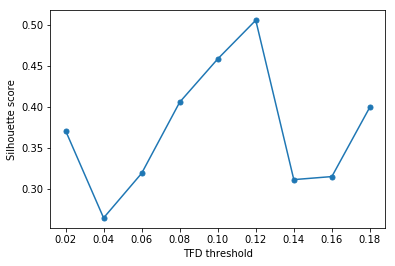

In [191]:
plt.plot(tfd_thresholds, silhouette_scores, marker='.', markersize=10)
plt.ylabel("Silhouette score")
plt.xlabel("TFD threshold")

In [216]:
# MD
rmsd_thresholds = [0.20, 0.40, 0.60, 0.80, 1.00]
md_clusters_rmsd = []
md_silhouette_scores = []
for t in rmsd_thresholds:
    clusters = cluster_mat(md_rmsd, method='single', threshold=t) # cluster indices for each of the inp observations
    md_clusters_rmsd.append(clusters)
#     Results of fcluster can directly be fed into silhouette_score.
#     https://stackoverflow.com/questions/27875056/how-to-calculate-silhouette-score-of-the-scipys-fcluster-using-scikit-learn-sil
    score = metrics.silhouette_score(md_rmsd, labels=clusters, metric='precomputed')
    md_silhouette_scores.append(score)

Text(0.5,0,'RMSD threshold (A)')

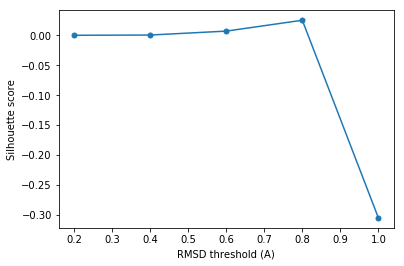

In [217]:
plt.plot(rmsd_thresholds, md_silhouette_scores, marker='.', markersize=10)
plt.ylabel("Silhouette score")
plt.xlabel("RMSD threshold (A)")

In [209]:
tfd_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
md_clusters_tfd = []
md_silhouette_scores = []
for t in tfd_thresholds:
    clusters = cluster_mat(md_tfd, method='single', threshold=t) # cluster indices for each of the inp observations
    md_clusters_tfd.append(clusters)
#     Results of fcluster can directly be fed into silhouette_score.
#     https://stackoverflow.com/questions/27875056/how-to-calculate-silhouette-score-of-the-scipys-fcluster-using-scikit-learn-sil
    score = metrics.silhouette_score(md_tfd, labels=clusters, metric='precomputed')
    md_silhouette_scores.append(score)

Text(0.5,0,'TFD threshold')

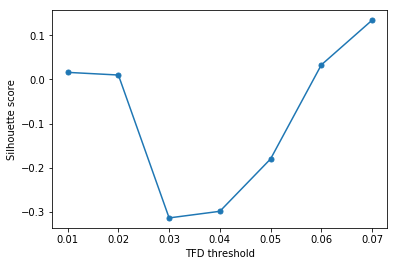

In [210]:
plt.plot(tfd_thresholds, md_silhouette_scores, marker='.', markersize=10)
plt.ylabel("Silhouette score")
plt.xlabel("TFD threshold")

In [ ]:
argsort_silhouette_samples = np.argsort(silhouette_samples)

### PyMol

In [ ]:
from rdkit.Chem import PyMol # # https://www.rdkit.org/docs/source/rdkit.Chem.PyMol.html
v = PyMol.MolViewer() # does not work on Chem.MolFromSmiles() for some reason

### PCA on IQMol data (using cartesian coordinates of non-H atoms)

In [299]:
print("conformer utility functions here in this minimized cell")
def get_conformers_xyz(mol, cids=[0]):
    """
    Parameters
    ----------
    mol: RDKit Molecule
    cids: list of confomer IDs of mol

    Returns
    -------
    xyz: (n_confs, n_atoms, 3) numpy array of cartesian coordinates
    """
    n_confs = len(cids)
    n_atoms = mol.GetNumAtoms()
    # coords = np.zeros((, 3))
    xyz = np.zeros((n_confs, n_atoms, 3))

    for i, cid in enumerate(cids):
        conf = mol.GetConformer(id=cid)
        # RDKit Point3D object
        point3d_coords = [conf.GetAtomPosition(j) for j in range(n_atoms)]
        # for each conformer, insert the xyz atom coordinates
        xyz[i, :, :] = point3d_coords

    return xyz

def get_cids(mol):
    """
    Parameters
    ----------
    mol: RDKit molecule

    Returns
    -------
    cids: list of all conformer IDs of mol
    """
    cids = []
    for conf in mol.GetConformers():
        cids.append(conf.GetId())
    return cids

conformer utility functions here in this minimized cell


In [346]:
iqmol_mol = Chem.RemoveHs(iqmol_mol_rmsd)
# print(iqmol_mol.GetNumConformers())
# print(iqmol_mol_rmsd.GetConformer(id=1).GetNumAtoms())
# print(iqmol_mol.GetConformer(id=1).GetNumAtoms())

# alignment with first conformer as reference
# rmslist = []
# Chem.rdMolAlign.AlignMolConformers(iqmol_mol, RMSlist=rmslist)

iqmol_cids = get_cids(iqmol_mol)
xyz = get_conformers_xyz(iqmol_mol, iqmol_cids)

# alignment using mdtraj
traj = mdtraj.Trajectory(xyz, topology=None)
traj.superpose(traj, 0)
print("n samples X d features: ", traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3).shape)

n samples X d features:  (83, 72)


In [347]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [328]:
pca1 = PCA(n_components=40)
reduced_cartesian = pca1.fit_transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
loadings = pca1.components_.T * np.sqrt(pca1.explained_variance_)
print(reduced_cartesian.shape)

(83, 40)


In [329]:
# energy colormap
iqmol_energies = confgen.get_conformer_energies(iqmol_mol_rmsd)

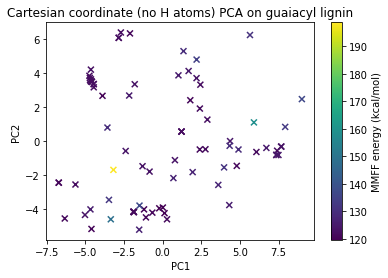

In [330]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=iqmol_energies)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate (no H atoms) PCA on guaiacyl lignin')
cbar = plt.colorbar()
cbar.set_label('MMFF energy (kcal/mol)')

Text(0.5,0,'PC')

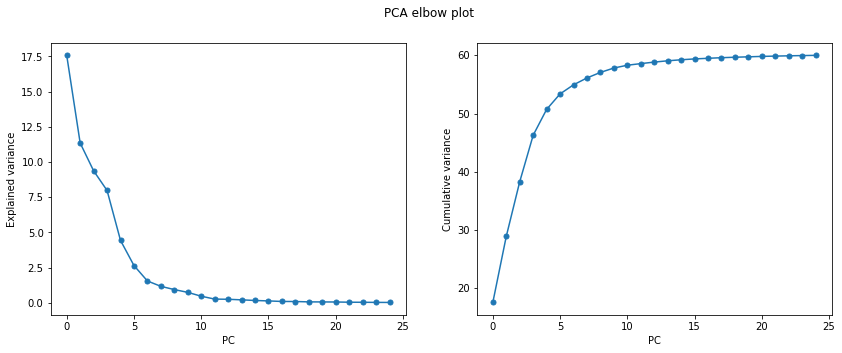

In [391]:
f, axs = plt.subplots(1,2,figsize=(14,5))
f.suptitle("PCA elbow plot")

plt.subplot(1,2,1)
plt.plot(range(25), pca1.explained_variance_[:25], marker='.', markersize=10)
plt.ylabel("Explained variance")
plt.xlabel("PC")

plt.subplot(1,2,2)
cum_vars = []
cum_var = 0
for var in pca1.explained_variance_:
    cum_var += var
    cum_vars.append(cum_var)
plt.plot(range(25), cum_vars[:25], marker='.', markersize=10) 
plt.ylabel("Cumulative variance")
plt.xlabel("PC")

In [399]:
## K-means clustering
# https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
PCA_components = pd.DataFrame(reduced_cartesian)

n_PC = 10 # from the scree plot
ks = range(1, len(iqmol_cids))
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, tol=1e-8)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:n_PC])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

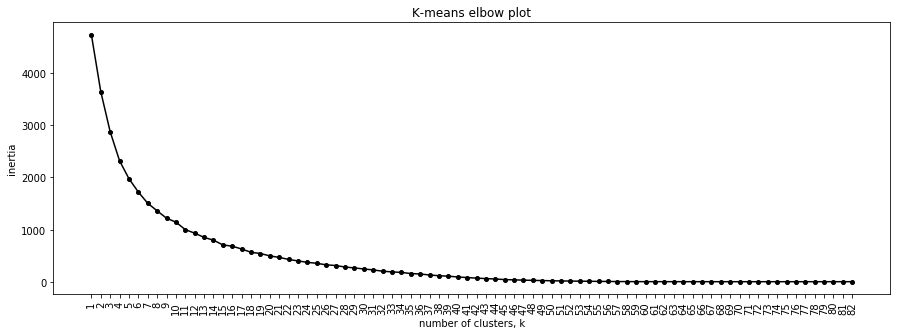

In [400]:
plt.figure(figsize=(15,5))
plt.title("K-means elbow plot")
plt.plot(ks, inertias, '-o', markersize=4, color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks, rotation=90)
plt.show()

In [423]:
k = 11
kmeans = KMeans(n_clusters=k, tol=1e-8)
kmeans.fit(PCA_components.iloc[:,:n_PC]) # lower dim # of PCs
centroids = kmeans.cluster_centers_ # (n_clusters, n_features)
labels = kmeans.labels_

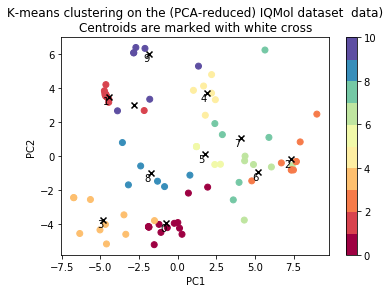

In [424]:
# https://stackoverflow.com/questions/52752836/organizing-clusters-in-k-means-clustering/52770392
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], c=labels, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='black')
plt.title('K-means clustering on the (PCA-reduced) IQMol dataset  data)\n'
          'Centroids are marked with white cross')

plt.xlabel('PC1')
plt.ylabel('PC2')
labels = ['{0}'.format(i) for i in range(10)]
for i in range (10):
    xy=(centroids[i, 0],centroids[i, 1])
    plt.annotate(labels[i], xy, horizontalalignment='right', verticalalignment='top')
plt.show()

### PCA on IQMol data (using torsion fingerprints)